In [10]:
!pip install mlflow


In [11]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load dataset
df = pd.read_csv("medical_insurance.csv")

# Features and target
X = df.drop("charges", axis=1)
y = df["charges"]

# Categorical and numerical columns
cat_cols = ["sex", "smoker", "region"]
num_cols = ["age", "bmi", "children"]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

# Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLflow tracking
mlflow.set_experiment("Medical_Insurance_Prediction")

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        pipe = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        mlflow.log_param("model_name", name)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        mlflow.sklearn.log_model(pipe, name)

        print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.2f}")


2025/08/20 05:26:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/20 05:26:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/20 05:26:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LinearRegression: RMSE=6319.27, MAE=4160.25, R2=0.74


2025/08/20 05:27:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/20 05:27:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Ridge: RMSE=6320.10, MAE=4164.81, R2=0.74


2025/08/20 05:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Lasso: RMSE=6319.30, MAE=4160.16, R2=0.74


2025/08/20 05:27:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/20 05:27:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/20 05:27:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForest: RMSE=2726.02, MAE=1299.07, R2=0.95


2025/08/20 05:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost: RMSE=2649.89, MAE=1206.39, R2=0.95


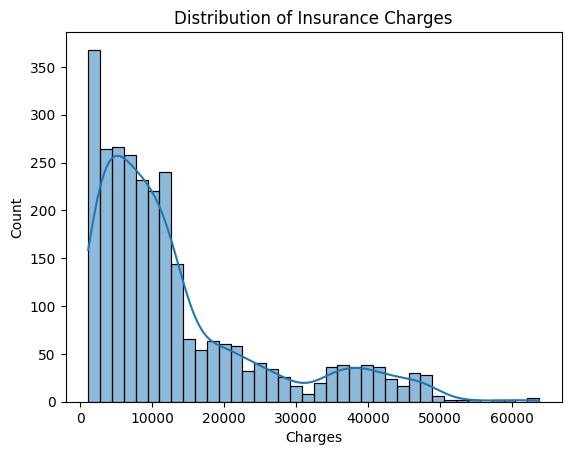

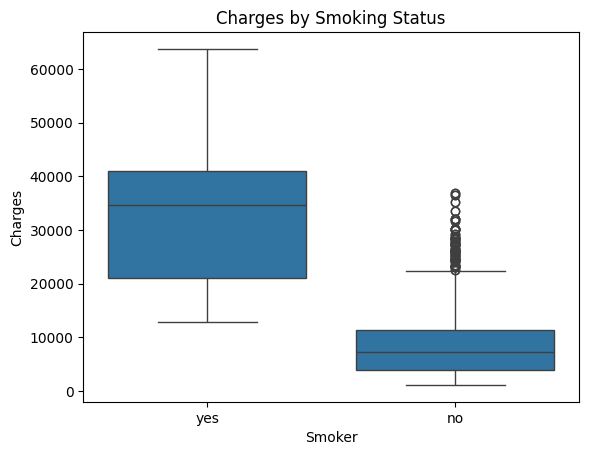

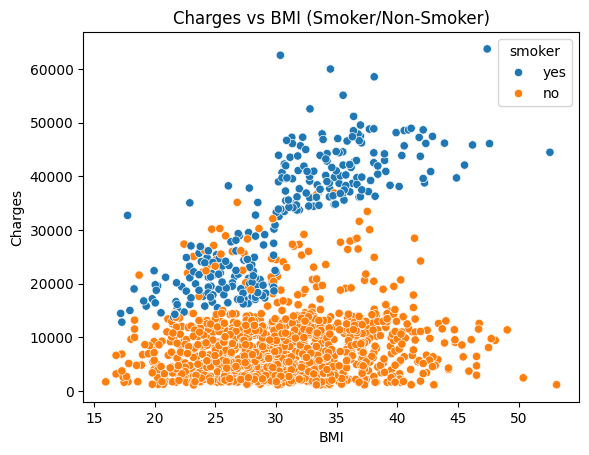

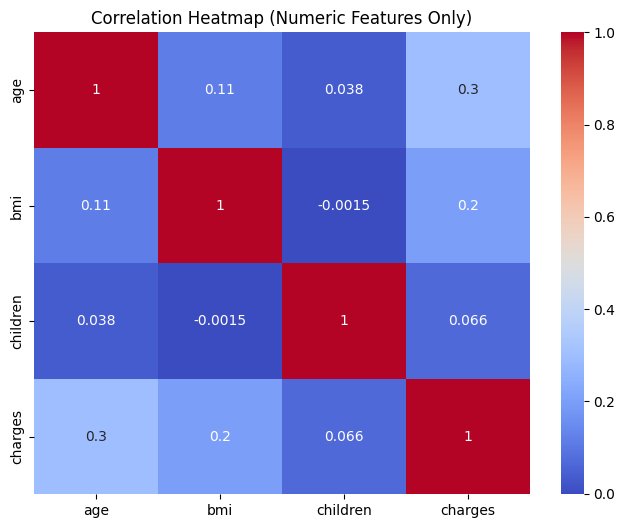

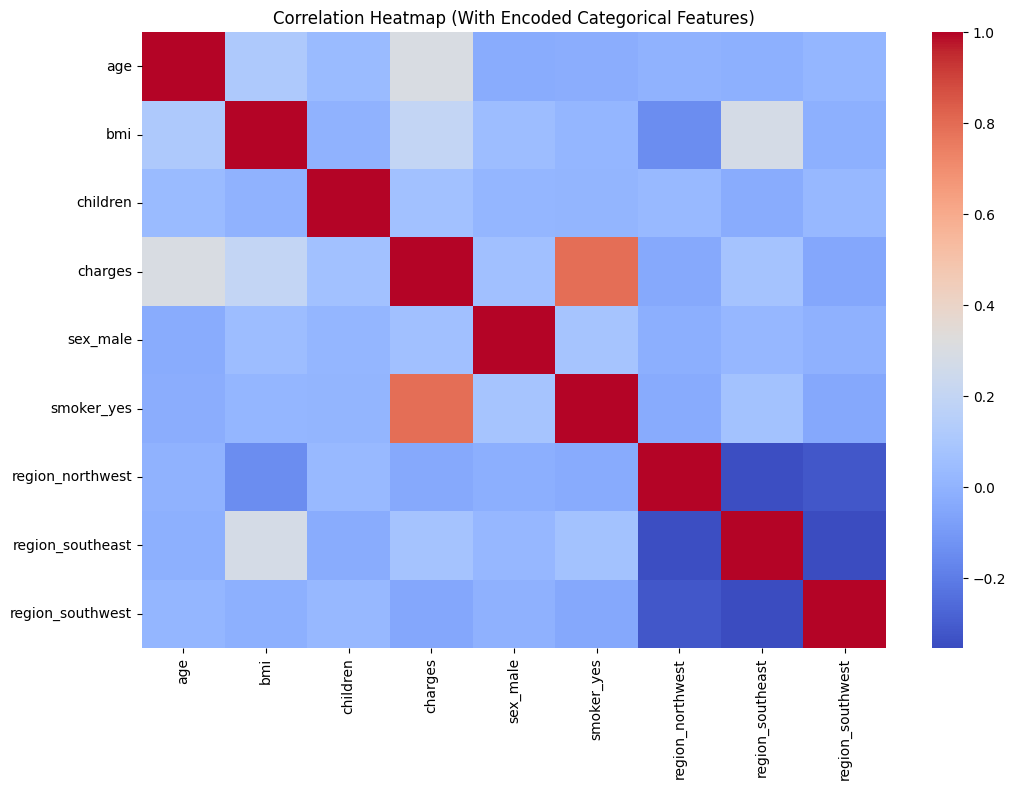

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("medical_insurance.csv")

# ----------------------------
# 1. Distribution of charges
# ----------------------------
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.show()

# ----------------------------
# 2. Charges vs Smoking Status
# ----------------------------
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges by Smoking Status")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()

# ----------------------------
# 3. Charges vs BMI (Smoker/Non-Smoker)
# ----------------------------
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df)
plt.title("Charges vs BMI (Smoker/Non-Smoker)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

# ----------------------------
# 4. Correlation Heatmap
# ----------------------------

# Option A: Numeric features only
numeric_df = df.select_dtypes(include=["int64", "float64"])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# Option B: Include categorical (One-hot encode first)
encoded_df = pd.get_dummies(df, drop_first=True)  # converts categorical to numeric
plt.figure(figsize=(12,8))
sns.heatmap(encoded_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (With Encoded Categorical Features)")
plt.show()


In [13]:
!pip install streamlit


In [14]:
import streamlit as st
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1. Train & Log Model in MLflow
# -----------------------------

@st.cache_resource  # ensures model is trained only once
def train_and_log_model():
    # Load dataset
    df = pd.read_csv("medical_insurance.csv")

    # Features & target
    X = df.drop("charges", axis=1)
    y = df["charges"]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Categorical & numeric columns
    categorical = ["sex", "smoker", "region"]
    numeric = ["age", "bmi", "children"]

    # Preprocessing
    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(drop="first"), categorical),
        ("num", "passthrough", numeric)
    ])

    # Model pipeline
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ])

    # Train
    model.fit(X_train, y_train)

    # Evaluate
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # Log to MLflow
    with mlflow.start_run() as run:
        mlflow.log_metric("rmse", rmse)
        mlflow.sklearn.log_model(model, "model")
        run_id = run.info.run_id

    return run_id

# Train and log model, get run_id
best_run_id = train_and_log_model()

# -----------------------------
# 2. Load model from MLflow
# -----------------------------
model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

# -----------------------------
# 3. Streamlit UI
# -----------------------------
st.title("🏥 Medical Insurance Cost Prediction")

age = st.slider("Age", 18, 100, 30)
sex = st.selectbox("Sex", ["male", "female"])
bmi = st.number_input("BMI", 10.0, 50.0, 25.0)
children = st.slider("Children", 0, 5, 0)
smoker = st.selectbox("Smoker", ["yes", "no"])
region = st.selectbox("Region", ["northeast", "northwest", "southeast", "southwest"])

# Input DataFrame
input_df = pd.DataFrame({
    "age": [age],
    "sex": [sex],
    "bmi": [bmi],
    "children": [children],
    "smoker": [smoker],
    "region": [region]
})

# Predict
if st.button("Predict Insurance Cost"):
    prediction = model.predict(input_df)
    st.success(f"💰 Estimated Insurance Cost: ${prediction[0]:,.2f}")


2025-08-20 05:27:27.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.891 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.892 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.894 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.895 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-20 05:27:27.896 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [15]:
import pytest
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

@pytest.fixture
def sample_data():
    data = {
        "age": [25, 45, 30, 60],
        "sex": ["male", "female", "female", "male"],
        "bmi": [22.5, 30.1, 27.3, 35.5],
        "children": [0, 2, 1, 3],
        "smoker": ["no", "yes", "no", "yes"],
        "region": ["southeast", "northwest", "southwest", "northeast"],
        "charges": [2000, 15000, 4000, 30000]
    }
    return pd.DataFrame(data)

def test_pipeline_training(sample_data):
    X = sample_data.drop("charges", axis=1)
    y = sample_data["charges"]

    cat_cols = ["sex", "smoker", "region"]
    num_cols = ["age", "bmi", "children"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first"), cat_cols)
        ]
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ])

    model.fit(X, y)
    preds = model.predict(X)

    # Test shape
    assert preds.shape[0] == X.shape[0]

    # Test predictions are numeric
    assert np.issubdtype(preds.dtype, np.number)

    # Predictions should not be negative
    assert all(pred >= 0 for pred in preds)


In [16]:
import pytest
import pandas as pd
import mlflow.pyfunc

@pytest.fixture
def sample_input():
    return pd.DataFrame({
        "age": [35],
        "sex": ["male"],
        "bmi": [28.0],
        "children": [2],
        "smoker": ["no"],
        "region": ["southeast"]
    })

def test_model_prediction(sample_input):
    # Load best model (replace run_id with actual one)
    model = mlflow.pyfunc.load_model("runs:/<best_run_id>/model")

    pred = model.predict(sample_input)

    # Check type
    assert isinstance(pred[0], (float, int))

    # Insurance cost should be within a reasonable range
    assert pred[0] > 1000 and pred[0] < 100000


In [ ]:
pytest -v
